In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
%matplotlib inline

In [67]:
def phi_pol(x, orden):
    pol = []
    for i in orden:
            pol.append(x**int(i))
    return np.array(pol).T


def modelo2(x, pre_mod, params):
    m = pre_mod + params[0]*np.sin(params[1]*x + params[2])*np.exp(params[3]*x)
    return m


def log_like(params, x, y, pre_mod, sigma_e, modelo):
    mod = modelo(x, pre_mod, params)
    arg = - 0.5*(len(y)*np.log(2*np.pi*sigma_e**2) + np.sum((y - mod)**2)/sigma_e**2)
    return - 1*arg # esta con el -1 para asi minimizar esa funcion


def MAP(x, y, orden, basis='pol', reg=0):
    """
    Retorna:
    t: estimador MAP
    """
    d = len(orden)
    if basis=='pol':
        p = phi_pol(x, orden=orden)
    # t = np.linalg.inv(p.T@p + reg*np.ones((d, d)))@p.T@y
    t = np.linalg.solve(p.T@p + reg*np.ones((d, d)), p.T@y)
    return t


def error(y_real, y_mod):
    return np.sum((y_real - y_mod)**2)/len(y_real)

$Y = \Phi(X) \theta + \eta$

$\theta_{\text{MAP}} = (\Phi^{T}(X)\Phi(X))^{-1} \Phi^{T}(X) Y$

$\theta_{\text{MAP REG}} = (\Phi^{T}(X)\Phi(X) + \rho \mathbb{1})^{-1} \Phi^{T}(X) Y$

$\Phi(X) \in N \text{x} D$

$\rho = \frac{\sigma_{\epsilon}^{2}}{\sigma_{\theta}^{2}}$

Donde $\sigma_{\theta}^{2}$ es la varianza del prior y $\sigma_{\epsilon}^{2}$ es la varianza del error de medición. 

Text(0.5,1,'conjunto de datos')

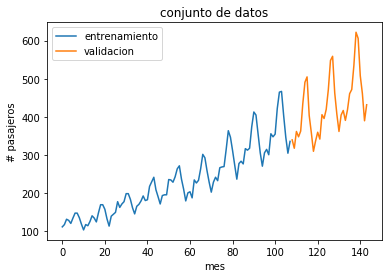

In [10]:
data = np.loadtxt('datosT2.txt')
n_train = int(12*9)
mes_train = data[:n_train, 0]
pax_train = data[:n_train, 1]
mes_val = data[n_train:, 0]
pax_val = data[n_train:, 1]
plt.plot(mes_train, pax_train, label='entrenamiento')
plt.plot(mes_val, pax_val, label='validacion')
plt.legend()
plt.xlabel('mes')
plt.ylabel('# pasajeros')
plt.title('conjunto de datos')

reg 1.0


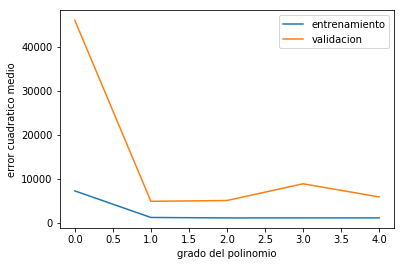

In [84]:
s_e = 1 # std datos
s_t = 1 # std params
rho = (s_e/s_t)**2 # constante de regularizacion
print('reg', rho)

n_max = 4
e_t = []
e_v = []
for i in range(n_max + 2)[1:]:
    theta_map = MAP(mes_train, pax_train, orden=np.arange(0, i, 1), basis='pol', reg=rho)
    p_train = phi_pol(mes_train, orden=np.arange(0, i, 1))
    p_val = phi_pol(mes_val, orden=np.arange(0, i, 1))
    mod1 = p_train@theta_map
    val1 = p_val@theta_map
    e_train = error(pax_train, mod1)
    e_val = error(pax_val, val1)
    e_t.append(e_train)
    e_v.append(e_val)
plt.plot(np.arange(0, n_max + 1, 1), e_t, label='entrenamiento')
plt.plot(np.arange(0, n_max + 1, 1), e_v, label='validacion')
#plt.ylim([0, 10000])
plt.xlabel('grado del polinomio')
plt.ylabel('error cuadratico medio')
plt.legend()


Se elige en 2 el grado del polinomio.

In [86]:
p_train = phi_pol(mes_train, orden=np.arange(0, 3, 1))
p_val = phi_pol(mes_val, orden=np.arange(0, 3, 1))
theta_map = MAP(mes_train, pax_train, orden=np.arange(0, 3, 1), basis='pol', reg=rho)
mod1 = p_train@theta_map
val1 = p_val@theta_map

theta_map = [1.11131564e+02 1.54976873e+00 9.33984556e-03]
error de entrenamiento = 5075.006593665244


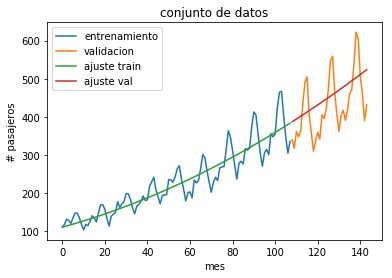

In [87]:
data = np.loadtxt('datosT2.txt')
n_train = int(12*9)
mes_train = data[:n_train, 0]
pax_train = data[:n_train, 1]
mes_val = data[n_train:, 0]
pax_val = data[n_train:, 1]
plt.plot(mes_train, pax_train, label='entrenamiento')
plt.plot(mes_val, pax_val, label='validacion')
plt.plot(mes_train, mod1, label='ajuste train')
plt.plot(mes_val, val1, label='ajuste val')
plt.legend()
plt.xlabel('mes')
plt.ylabel('# pasajeros')
plt.title('conjunto de datos')

print('theta_map =', theta_map)
print('error de entrenamiento =', error(pax_val, val1))

x0 = [3.15768283 0.62831853 5.6332823  0.01      ]
xf = [4.7756851  1.5615854  4.14860047 0.00677801]
error de entrenamiento = 4976.064265301762
converge False


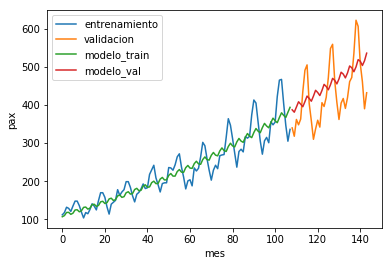

In [99]:
plt.plot(mes_train, pax_train, label='entrenamiento')
plt.plot(mes_val, pax_val, label='validacion')
plt.xlabel('mes')
plt.ylabel('pax')

t1 = np.random.uniform(1, 10)
t2 = 2*np.pi/10
t3 = np.random.uniform(0, 2*np.pi)
x0 = np.array([t1, t2, t3, 0.01])
tol = 1e-3

res2 = minimize(fun=log_like, x0=x0, args=(mes_train, pax_train, mod1, s_e, modelo2), method='BFGS', tol=tol)
mod2 = modelo2(x=mes_train, pre_mod=mod1, params=res2.x)
val2 = modelo2(x=mes_val, pre_mod=val1, params=res2.x)
plt.plot(mes_train, mod2, label='modelo_train')
plt.plot(mes_val, val2, label='modelo_val')
plt.legend()

print('x0 =', x0)
print('xf =', res2.x)
print('error de entrenamiento =', error(pax_val, val2))
print('converge', res2.success)

x0 = [4.667165   1.25663706 0.88392173 0.01      ]
xf = [ 1.11167141e+02 -1.13772697e-01  1.49519700e+00 -6.31732049e-02]
error de entrenamiento = 107359.99
converge True


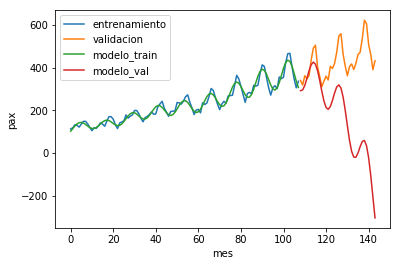

In [15]:
plt.plot(mes_train, pax_train, label='entrenamiento')
plt.plot(mes_val, pax_val, label='validacion')
plt.xlabel('mes')
plt.ylabel('pax')

t1 = np.random.uniform(1, 10)
t2 = 2*np.pi/5
t3 = np.random.uniform(0, 2*np.pi)
x0 = np.array([t1, t2, t3, 0.01])

res3 = minimize(fun=log_like, x0=x0, args=(mes_train, pax_train, mod2, s_e, modelo2), method='BFGS', tol=tol)
mod3 = modelo2(x=mes_train, pre_mod=mod2, params=res3.x)
val3 = modelo2(x=mes_val, pre_mod=val2, params=res3.x)
plt.plot(mes_train, mod3, label='modelo_train')
plt.plot(mes_val, val3, label='modelo_val')
plt.legend()

print('x0 =', x0)
print('xf =', res3.x)
print('error de entrenamiento =', error(pax_val, val3))
print('converge', res3.success)

In [16]:


phi_pol(np.arange(0, 10, 1), [0, 1, 2, 3])

array([[  1,   0,   0,   0],
       [  1,   1,   1,   1],
       [  1,   2,   4,   8],
       [  1,   3,   9,  27],
       [  1,   4,  16,  64],
       [  1,   5,  25, 125],
       [  1,   6,  36, 216],
       [  1,   7,  49, 343],
       [  1,   8,  64, 512],
       [  1,   9,  81, 729]])